# ДЗ по "Введение в нейронные сети (Вебинар)"

## Вебинар 3. TensorFlow 
* Домашнее задание:  
  -	Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. 
Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точност;  
  -	Поработайте с документацией TensorFlow. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке;  
  -	*Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews.
   
Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность. чность

In [1]:
# Устанавливаем пакеты в окружение, если они не установлены
# !pip install scikeras[tensorflow]
# !pip install numpy
# !pip install matplotlib

## Установим пакет tensorflow в окружение, если не установлен
см. [докуметация](https://www.tensorflow.org/install/pip?hl=ru)

In [2]:
# !python -m pip install --upgrade pip
# !pip install tensorflow

In [3]:
import keras
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Обучение и тестирование модели на Keras со сверточными слоями
Полезные ссылки:  
1. [сравнение tensorflow и keras](https://www.guru99.com/ru/tensorflow-vs-keras.html)
2. [свертка 1 сайт](https://habr.com/ru/companies/skillfactory/articles/565232/)
3. [свертка 2 сайт ](https://proglib.io/p/convolution)

In [4]:
# Импортиртируем набор данных (для обучения и тестовый) fashion_mnist из модуля Keras (картинки 28х28 пик. с изображением одежды) 
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Нормализуем данные (все данные в массиве, делим на 255)
x_train = x_train / 255
x_test = x_test / 255

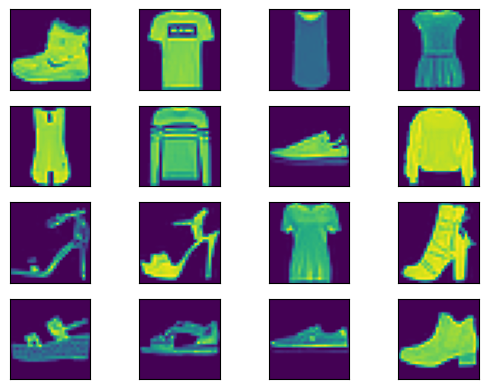

In [6]:
# Посмотрим, что за данные мы загрузили
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i])
    # Убираем подписи к осям рисунков
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
# Делаем категоризацию - преобразовывает вектор класса (целые числа) в двоичную матрицу класса
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [8]:
# Задаем входной формат данных для модели
input_shape = (28, 28, 1)

In [9]:
# Создаем модель Keras - последовательная модель Sequential
model_2 = keras.Sequential([
    keras.Input(shape=input_shape),   # устанавливаем входной формат данных
    Conv2D(32, padding='same', kernel_size = (3, 3), activation = 'relu'), # Задаем число фильтров (32) и размер матрицы свертывания (3x3)
    MaxPooling2D((2, 2), strides = 2), # Задаем размер квадратика при свертывании MaxPool (2x2)
    Conv2D(64, padding='same', kernel_size = (3, 3), activation = 'relu'), # Задаем число фильтров (32) и размер матрицы свертывания (3x3)
    MaxPooling2D((2, 2), strides = 2), # Задаем размер квадратика при свертывании MaxPool (2x2)
    Flatten(),                        # сглаживание
    Dense(90, activation = 'relu'),   # Слой нейронной сети из 90 нейронов и функцией активации 'relu'
    Dense(10, activation = 'softmax') # Слой нейронной сети из 10 нейронов и функцией активации 'softmax'
    ])

### Создаём callback EarlyStopping (защита от переобучения)
см. [ссылка ToTube](https://www.youtube.com/watch?v=aiH_oXtuzjE) 

In [10]:
# Настраиваем защиту от переобучения
erly_stoping_callback = EarlyStopping(monitor='val_accuracy', patience=2)  # Если метрика 'val_accuracy' продолжает снижение два шага подряд,
                                                                           # то выходим из процесса обучения

### Настраиваем скорость обучения
см. [ссылка](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay)

In [11]:
# Задаем переменные
EPOCH = 25                                 # Количество эпох обучения
BATCH_SIZE = 32                            # Сколько элементов массива обработает модель за один шаг обучения 
STEP_ONE_EPOCH = len(x_train)//BATCH_SIZE  # Сколько шагов в одной эпохе

In [12]:
# Настраиваем расписание обучения
boundaries = [STEP_ONE_EPOCH, STEP_ONE_EPOCH, 4*STEP_ONE_EPOCH]  # Устанавливаем количество шагов -> [1 эпоха, 1 эпоха, 4 эпохи]
values = [1e-3,0.5e-3,1e-4,0.5e-4]      # Устанавливаем коэ-т обучения, первые 3 коэф-та соответствуют шагам boundaries, а 4-й (0.5e-4), 
                                        # для всех остальных шагов 
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer_val = tf.keras.optimizers.Adam(lr_sched)

### Компилируем модель

In [13]:
# Компилируем модель
model_2.compile(optimizer=optimizer_val,       # выбираем оптимизатор
             loss='categorical_crossentropy',  # выбираем функцию потерь
             metrics=['accuracy'])             # выбираем метрику

In [14]:
%%time
# Обучение и сохранение истории обучения с одновременной оценкой на тестовых данных (чтобы удостовериться, что переобучения не произошло)
history = model_2.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=EPOCH, validation_data =(x_test, y_test_cat), 
                      callbacks=[erly_stoping_callback])

Epoch 1/25
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4147 - accuracy: 0.8487 - val_loss: 0.3318 - val_accuracy: 0.8778
Epoch 2/25
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2565 - accuracy: 0.9077 - val_loss: 0.2815 - val_accuracy: 0.8974
Epoch 3/25
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2395 - accuracy: 0.9129 - val_loss: 0.2741 - val_accuracy: 0.8985
Epoch 4/25
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2289 - accuracy: 0.9167 - val_loss: 0.2636 - val_accuracy: 0.9011
Epoch 5/25
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2161 - accuracy: 0.9211 - val_loss: 0.2572 - val_accuracy: 0.9061
Epoch 6/25
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2108 - accuracy: 0.9230 - val_loss: 0.2544 - val_accuracy: 0.9082
Epoch 7/25
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2067 - accuracy: 0.9244 - val_loss: 0.2537 -

In [15]:
if erly_stoping_callback.stopped_epoch >=1:
    print('Обучение остановлено на эпохе', erly_stoping_callback.stopped_epoch)

Обучение остановлено на эпохе 19


### Отрисовка потерь и точности модели (при обучении и на тестовых данных)

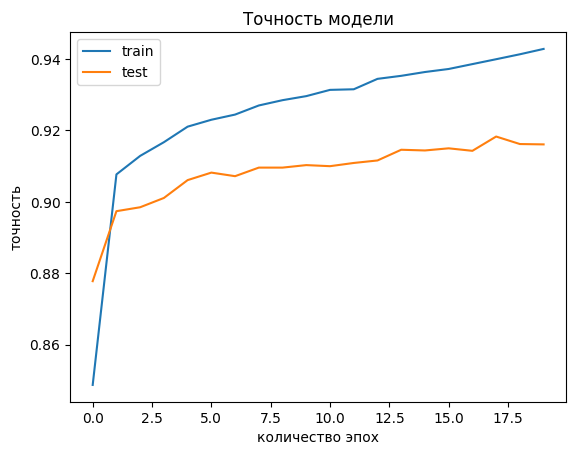

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

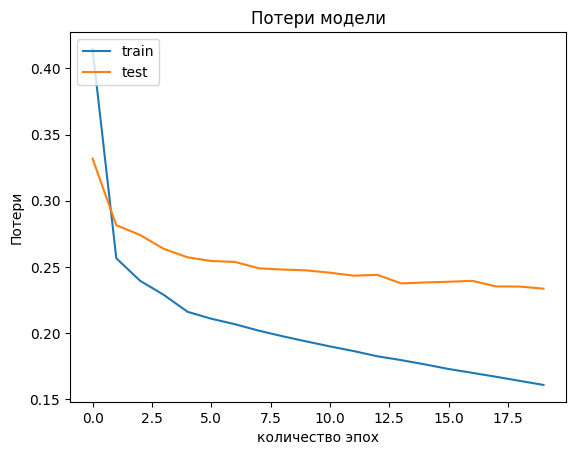

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Оценка модели

In [18]:
# Оцениваем работу загруженной модели на тестовых данных
results = model_2.evaluate(x_test, y_test_cat)
print('test loss, test acc:', results)

313/313 [==============================] - 1s 3ms/step - loss: 0.2335 - accuracy: 0.9161
test loss, test acc: [0.23354826867580414, 0.916100025177002]


In [19]:
# Смотрим архитектуру модели НС (слои, параметры, нейроны) 
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 90)                2

## Вывод: 
## Точность НС улучшить не удалось, я добавлял еще один сверточный слой, а также увеличивал/уменьшал число нейронов в слое Dense, менял оптимизатор, лучший результат который мне удалось получить - test loss, test acc: [0.233, 0.916]. 
## При работе с документацией, разобрался как предотвратить обучение модели и гибко настраивать скорость обучения.